## Demonstration of Image Captioning using the Show, Attend and Tell Model

This jupyter notebook is for demonstration of our show, attend and tell image captioning network trained on the MS COCO data split by Andrej Karpathy.  
The configuration of the network that is demonstrated in this notebook is given below.

__Configuration:__  
1. Encoder: VGG19 (Dimension = 512)
2. Decoder: LSTMCell + Deterministic Soft Attention
3. Teacher Forcing for Decoder Training: True
4. Optimizer: Adam
5. Loss function: Cross Entropy Loss
6. Regularization Constant (alpha_c): 1
7. Learning Rate: 4e-4
8. Step size for learning rate annealing: 5
9. Batch Size: 32
10. Number of epochs: 3
11. Beam size: 3 (For Optimal Caption Generation)

In [1]:
%matplotlib notebook
import json
import torch
from matplotlib import pyplot as plt

### Loading of the word dictionary (vocabulary) and the testing image paths

In [2]:
data_root_dir = 'data/coco'

# Loading the word dictionary for the network
word_dict = json.load(open(data_root_dir + '/word_dict.json', 'r'))
vocabulary_size = len(word_dict)

# Loading the test image paths
test_img_paths = json.load(open(data_root_dir + '/test_img_paths.json'))

### Loading the Pretrained Model 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")

device = cuda


In [4]:
from models import Encoder, Decoder

network = 'vgg19'
tf_ratio = 0        # Teacher Forcing will be used for training
lr = 4e-4           # Learning rate
batch_size = 32     # Batch size for mini-batch gradient descent
step_size = 5       # Step size for learning rate annealing
alpha_c = 1         # Regularization constant
start_epoch = 1     # Starting epoch for the experiment
log_interval = 100  # Frequency for logging statistics

log_filename = 'logs/log_tf_true.txt'

In [5]:
from generate_visualization import generate_caption_visualization, generate_image_caption

# Load the trained network (mainly the decoder into the decoder module)
encoder = Encoder(network)
decoder = Decoder(device, vocabulary_size, encoder.dim, tf_ratio = tf_ratio)

trained_model_path = 'models/model_tf_true.pth.tar'
decoder.load_state_dict(torch.load(trained_model_path)['state_dict'])

# Set the encoder and decoder in evaluation mode to get captions for testing data
encoder.eval()
decoder.eval()

Decoder(
  (init_h): Linear(in_features=512, out_features=512, bias=True)
  (init_c): Linear(in_features=512, out_features=512, bias=True)
  (tanh): Tanh()
  (f_beta): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (deep_output): Linear(in_features=512, out_features=10366, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): Attention(
    (U): Linear(in_features=512, out_features=512, bias=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(10366, 512)
  (lstm): LSTMCell(1024, 512)
)

### BLEU Scores of the Trained Model

In [6]:
from plot import processing_logfile

# Process the log file and get the bleu statistics data
_, _, bleu = processing_logfile(log_filename)

bold = '\033[1m'
end = '\033[0m'

# Printing the bleu scores for the last epoch
print(f'{bold}BLEU 1{end} Score on Validation Set: {bold} {bleu[2][0]} {end}\n')
print(f'{bold}BLEU 2{end} Score on Validation Set: {bold} {bleu[2][1]} {end}\n')
print(f'{bold}BLEU 3{end} Score on Validation Set: {bold} {bleu[2][2]} {end}\n')
print(f'{bold}BLEU 4{end} Score on Validation Set: {bold} {bleu[2][3]} {end}\n')

BLEU 1 Score on Validation Set:  0.7140651187315218 

BLEU 2 Score on Validation Set:  0.5125747313875666 

BLEU 3 Score on Validation Set:  0.3653013052060429 

BLEU 4 Score on Validation Set:  0.2561268740835117 



### Correctly Captioned Images by the Model on the Testing Dataset

<IPython.core.display.Javascript object>


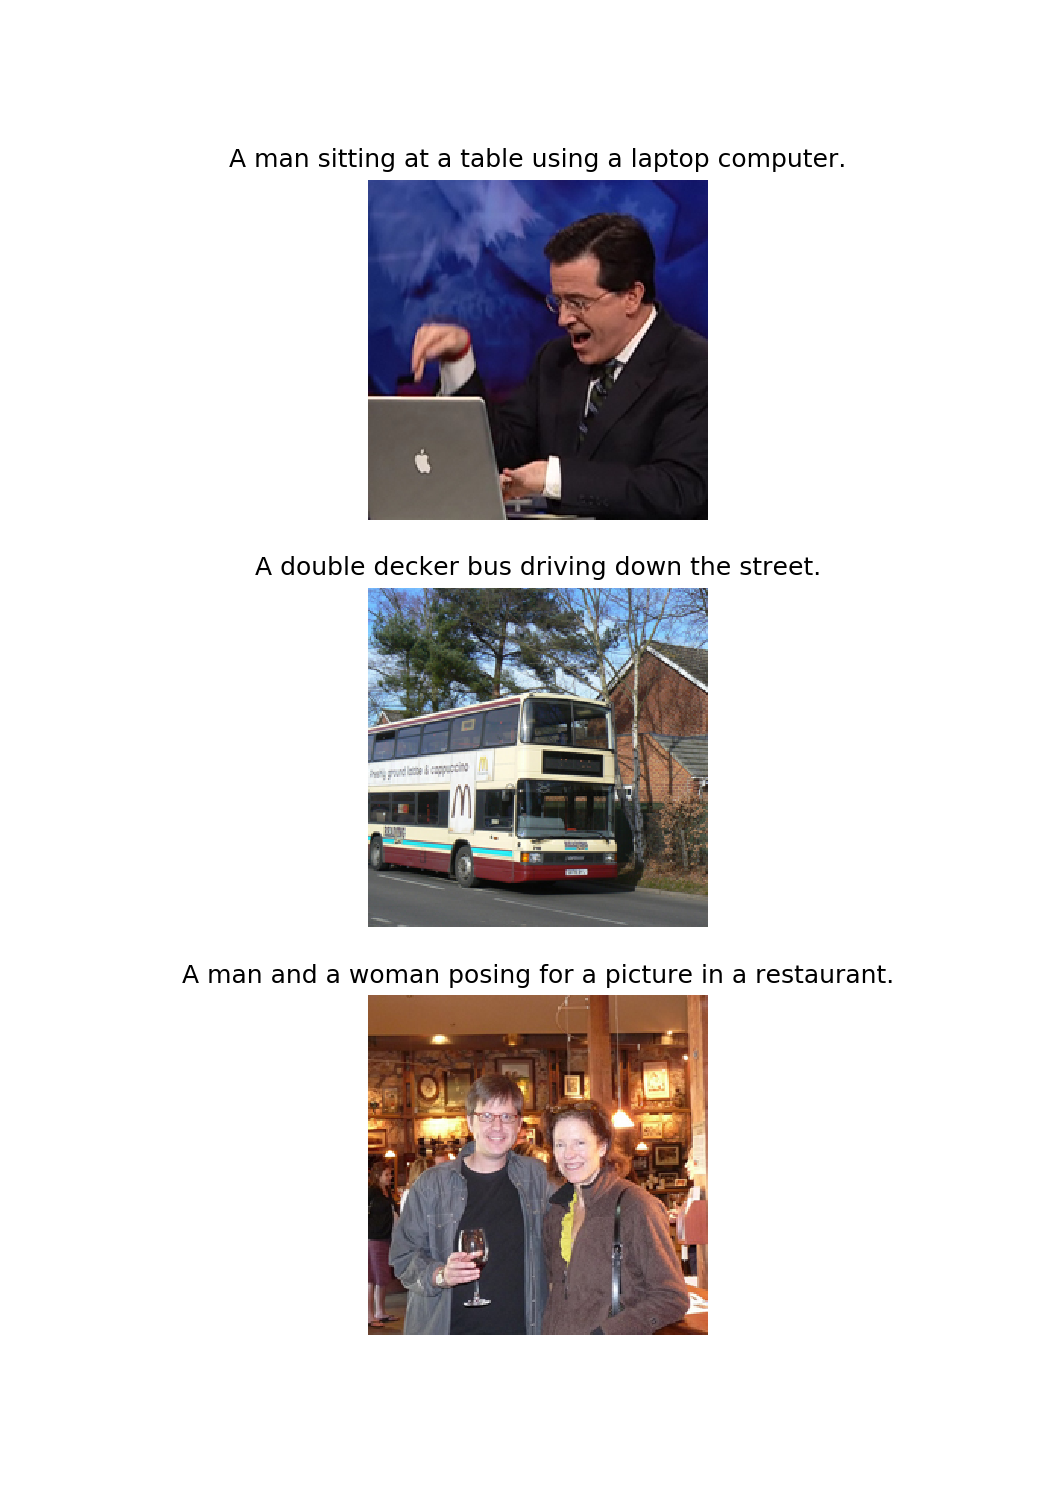

In [7]:
fig, axes = plt.subplots(nrows=3, figsize=(7,10))

generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['38822'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['17691'], word_dict, beam_size=3, ax=axes[1])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[2])

### Incorrectly Captioned Images on the Testing Dataset

<IPython.core.display.Javascript object>


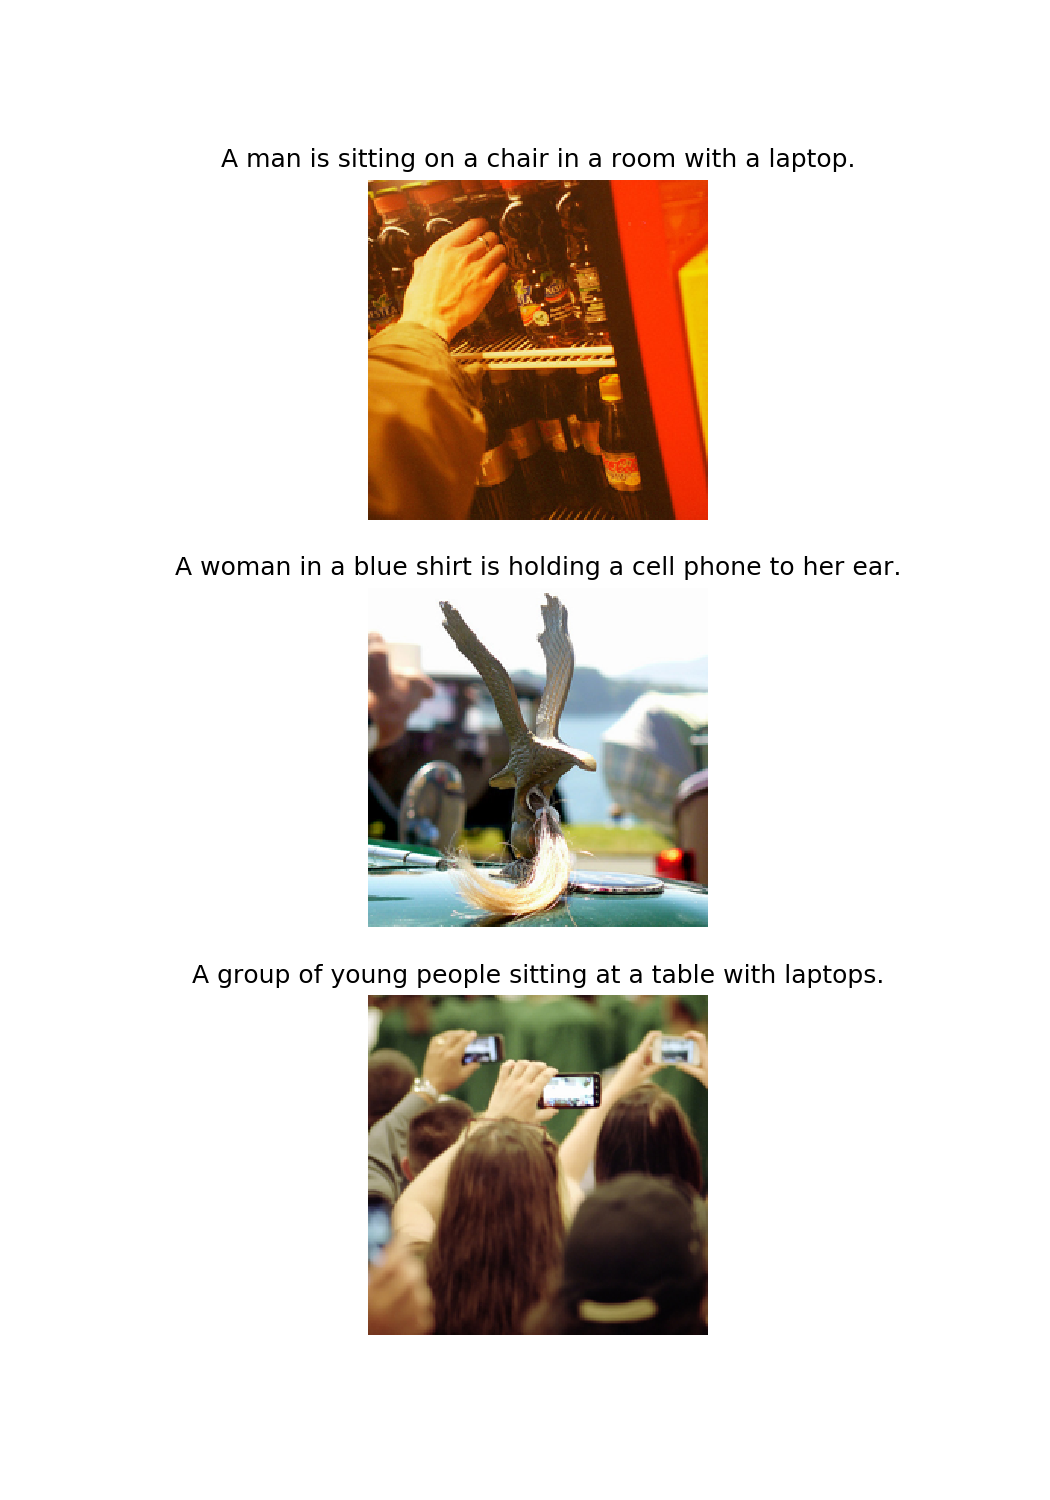

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(7,10))

generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['22456'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['32828'], word_dict, beam_size=3, ax=axes[1])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16300'], word_dict, beam_size=3, ax=axes[2])

### Visualization of Attention and the Corresponding Caption Generation

<IPython.core.display.Javascript object>


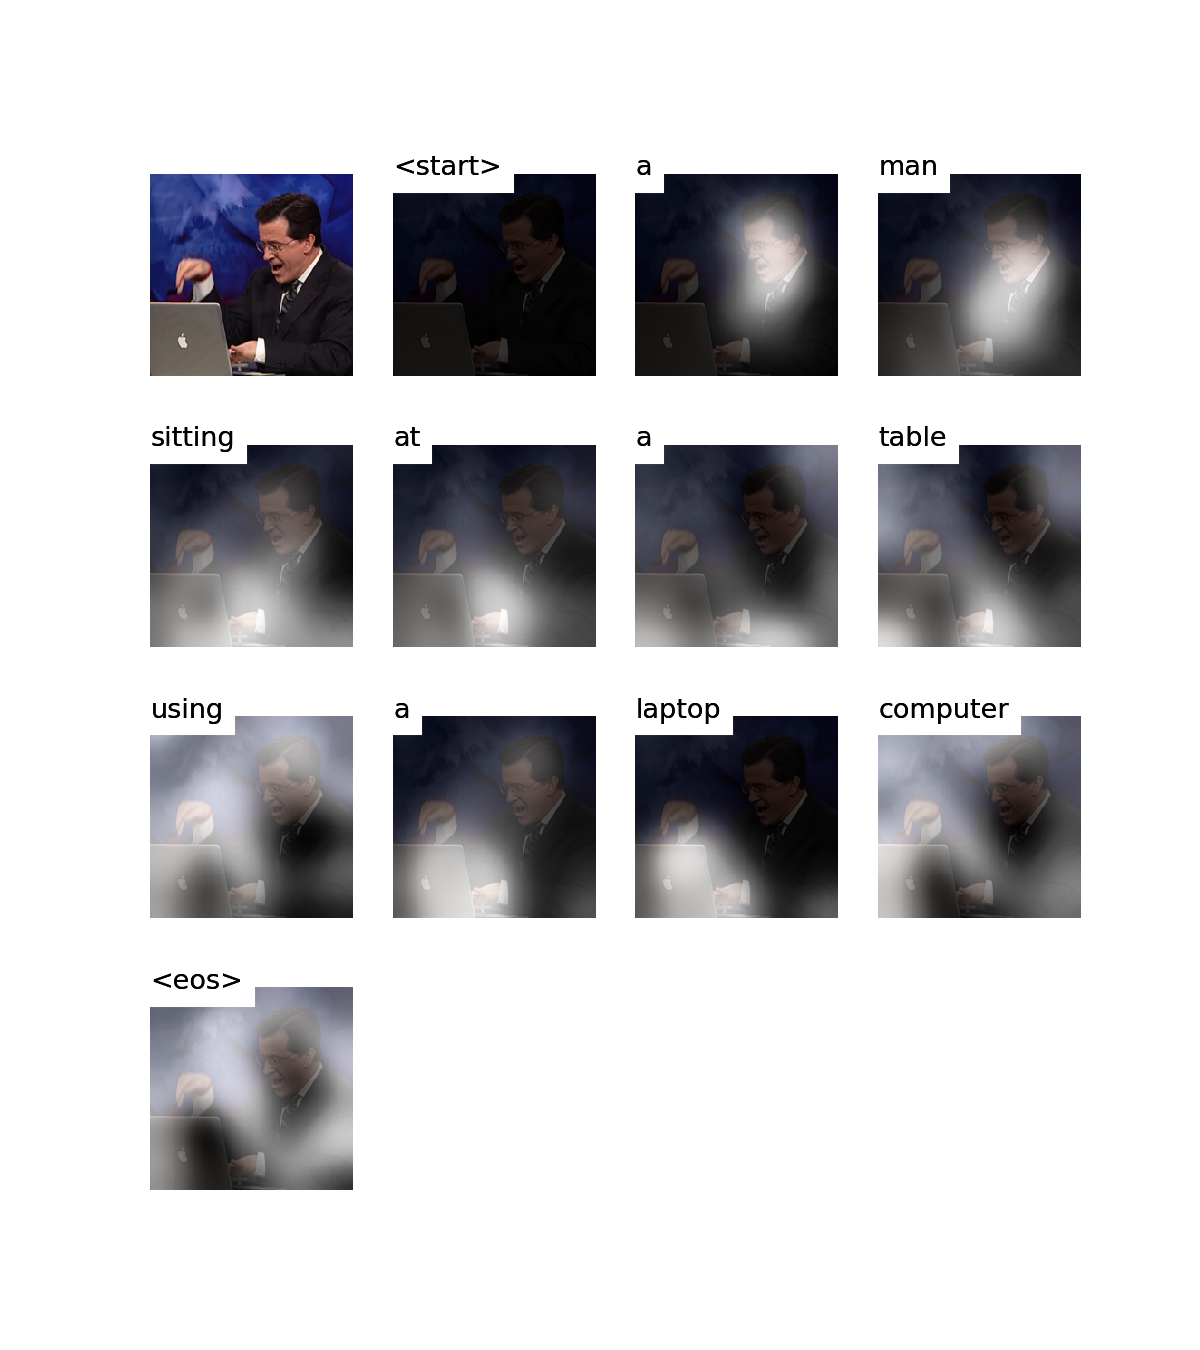

/opt/conda/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [9]:
# Visualization for a correctly classified image

generate_caption_visualization(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['38822'], word_dict, beam_size=3)

This visualization enables us to understand how the caption is generated by the network by focusing on different elements in the image using the attention module. For example, in the visualization above, the model starts by focusing on the man's face. By this it determines that the object is a man. In addition, it analyzes the immediate neighborhood of the man to identify that he is sitting and has a table in front of him. Finally, the focus is brought on the device on the table which is then captioned as a laptop computer. It is possible that through the use of hard attention, the redundant word computer could have been dropped from the caption by not focusing on an already captioned portion of the image twice.

In [10]:
# Visualization for an incorrectly classified image

generate_caption_visualization(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['32828'], word_dict, beam_size=3)

<IPython.core.display.Javascript object>

In case of this incorrectly classified image, the object in focus is slightly unusual and in addition there is a blurred background. This could be the reason that the network is unable to identify critical objects and classify them based on the dictionary such as the car and its logo. Also, the attention learnt during each cycle is mostly spread out over the entire image. This is prohibiting the network from making clear predictions. Restricting the variance of the attention might help in bringing in greater focus and better captioning. Also, image captioning is known to use the frequently occurring words for images it cannot interpret. This can be seen in the above image as well, as it uses words such as woman and cell phone which are more frequently occuring words in the dictionary.

### Progression of the Captions over the three epochs

In [11]:
fig, axes = plt.subplots(nrows=2, figsize=(7,7))

# Load the trained network of epoch 1 (mainly the decoder into the decoder module)
encoder1 = Encoder(network)
decoder1 = Decoder(device, vocabulary_size, encoder.dim, tf_ratio = tf_ratio)

trained_model_path = 'models/model_tf_true_epoch1.pth.tar'
decoder1.load_state_dict(torch.load(trained_model_path)['state_dict'])

# Set the encoder and decoder in evaluation mode to get captions for testing data
encoder1.eval()
decoder1.eval()

generate_image_caption(encoder1, decoder1, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[1])

<IPython.core.display.Javascript object>

After the first epoch, the network is unable to differentiate man and woman. It is also not able to identify further details such as the background is a restaurant. However, it does do a good job at identifying the basic components in the image such as the people, standing and store. Over the epochs, the network learns more intricate details such as gender differentiation. After more number of epochs, the network will be able to identify the wine glass in the man's hand!

### Variations in Generated Captions with Beamsize

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(7,7))

generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=1, ax=axes[0])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=3, ax=axes[1])
generate_image_caption(encoder, decoder, data_root_dir +'/imgs'+test_img_paths['16375'], word_dict, beam_size=7, ax=axes[2])

<IPython.core.display.Javascript object>

Variation in beamsize has an interesting effect on the generated captions. In the first case when the beamsize is 1, the generated caption is made from the words that have the highest scores. The caption is correct but minimalistic. A beamsize of 3 gives us the most suitable caption for the image as it correctly captures the background and the action being performed. Further increase in the beamsize tends to distort the caption as the evaluation has too many options to choose from. Consequently, the produced caption is correct but loses a major portion of the details in the image.